In [1]:
xmin=-1.5
ymin=-1.0
xmax=0.5
ymax=1.0
resolution=300
xstep=(xmax-xmin)/resolution
ystep=(ymax-ymin)/resolution
xs=[(xmin+(xmax-xmin)*i/resolution) for i in range(resolution)]
ys=[(ymin+(ymax-ymin)*i/resolution) for i in range(resolution)]

In [26]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [3]:
def mandel(position,limit=50):
    value=position
    while abs(value)<2:
        limit-=1
        value=value**2+position
        if limit<0:
            return 0
    return limit

In [4]:
%%cython
def mandel_cython(position,limit=50):
    value=position
    while abs(value)<2:
        limit-=1
        value=value**2+position
        if limit<0:
            return 0
    return limit

In [5]:
data_cy=[[mandel_cython(complex(x,y)) for x in xs] for y in ys]

In [6]:
%%timeit
data_cy=[[mandel_cython(complex(x,y)) for x in xs] for y in ys]

1 loops, best of 3: 414 ms per loop


This is about a factor of 2 faster than the pure python.

But we can do much better, by telling Cython what C types we would use for the code:

In [7]:
%%cython
def typed_mandel_cython(position,limit=50):
    cdef double complex value
    value=position
    while abs(value)<2:
        limit-=1
        value=value**2+position
        if limit<0:
            return 0
    return limit

In [8]:
%%timeit
data_cy=[[typed_mandel_cython(complex(x,y)) for x in xs] for y in ys]

1 loops, best of 3: 350 ms per loop


We might not really seeing how well Cython is really doing, as our loop could now be the limit:

In [9]:
%%timeit
mandel(0)

100000 loops, best of 3: 9.22 µs per loop


In [10]:
%%timeit
mandel_cython(0)

100000 loops, best of 3: 4.19 µs per loop


In [11]:
%%timeit
typed_mandel_cython(0)

100000 loops, best of 3: 7.88 µs per loop


In [12]:
%%cython
cpdef call_typed_mandel_cython(double complex position,int limit=50):
    cdef double complex value
    value=position
    while abs(value)<2:
        limit-=1
        value=value**2+position
        if limit<0:
            return 0
    return limit

In [13]:
%%timeit
call_typed_mandel_cython(0)

100000 loops, best of 3: 2.94 µs per loop


Note we're not actually writing C, we're writing Python with C types.

We can call C functions instead of Python functions with appropriate imports. E.g., let's get complex abs from the C standard library.

In [14]:
%%cython
from libc.math cimport abs as cabs
cpdef mandel_cython_2(double complex position,int limit=50):
    cdef double complex value
    value=position
    while cabs(value)<2:
        limit-=1
        value=value**2+position
        if limit<0:
            return 0
    return limit

In [15]:
%%timeit
mandel_cython_2(0)

100000 loops, best of 3: 3.02 µs per loop


Cython integrates nicely with NumPy:

In [16]:
import numpy as np
ymatrix,xmatrix=np.mgrid[ymin:ymax:ystep,xmin:xmax:xstep]
values=xmatrix+1j*ymatrix

In [17]:
numpy_cython_1=np.vectorize(mandel_cython_2)

In [18]:
%%timeit 
numpy_cython_1(values)

10 loops, best of 3: 135 ms per loop


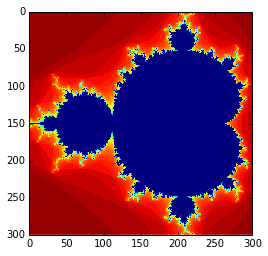

In [19]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(numpy_cython_1(values),interpolation='none')

Fast, but slower than our pure NumPy. Maybe explicit C-style looping is faster?

In [20]:
%%cython
import numpy as np
cimport numpy as np
cpdef numpy_cython_2(np.ndarray[double complex,ndim=2] position, int limit=50):
    cdef np.ndarray[long,ndim=2] diverged_at
    cdef double complex value
    cdef int xlim
    cdef int ylim
    cdef double complex pos
    cdef steps

    
    xlim=position.shape[1]
    ylim=position.shape[0]
    diverged_at=np.zeros([ylim, xlim], dtype=int)
    for y in range(ylim):
        for x in range(xlim):
             steps=limit
             value=position[y,x]
             pos=position[y,x]
             while abs(value)<2 and steps>=0:
                steps-=1
                value=value**2+pos
             diverged_at[y,x]=steps
  
    return diverged_at

In [21]:
%%timeit
numpy_cython_2(values)

1 loops, best of 3: 219 ms per loop


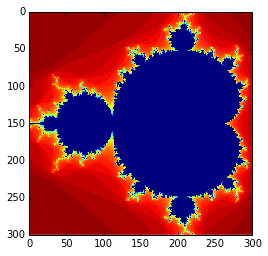

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(numpy_cython_2(values),interpolation='none')

Not yet faster.